In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy

In [9]:
# Generate the training image
training_data_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, rotation_range=15, width_shift_range=0.05, height_shift_range=0.05)
# training iterator
BATCH_SIZE=3
training_data_iterator = training_data_generator.flow_from_directory('Covid19-dataset/train', class_mode='categorical', color_mode='grayscale', batch_size=BATCH_SIZE)


# Generate the validation image that just perform pixel normalization
validation_data_generator = ImageDataGenerator(rescale=1/255)
validation_data_iterator = validation_data_generator.flow_from_directory('Covid19-dataset/test', class_mode='categorical', color_mode='grayscale', batch_size=BATCH_SIZE)
print(training_data_iterator)

# Create a optimizor
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [10]:
# Create a network
model = Sequential()
model.add(tf.keras.layers.Input(shape=(256,256,1)))
model.add(tf.keras.layers.Conv2D(4,5,strides=1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(tf.keras.layers.Conv2D(4,5,strides=1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 252, 252, 4)    │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 126, 126, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 122, 122, 4)    │           404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 40, 40, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │        19,203 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,711 (77.00 KB)

 Trainable params: 19,711 (77.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC(name='auc')])

In [12]:
# Fit the model into the training and validation data
history = model.fit(training_data_iterator, steps_per_epoch=int(training_data_iterator.samples/BATCH_SIZE), epochs=20, validation_data=validation_data_iterator, validation_steps=int(validation_data_iterator.samples/BATCH_SIZE))
print(history.history.keys())


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - auc: 0.6078 - categorical_accuracy: 0.4416 - loss: 1.0817 - val_auc: 0.8639 - val_categorical_accuracy: 0.6970 - val_loss: 0.7537
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6111 - categorical_accuracy: 0.3333 - loss: 1.0720 - val_auc: 0.8835 - val_categorical_accuracy: 0.7424 - val_loss: 0.7386
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - auc: 0.8897 - categorical_accuracy: 0.7171 - loss: 0.6557 - val_auc: 0.8687 - val_categorical_accuracy: 0.6970 - val_loss: 0.6814
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 1.0000 - categorical_accuracy: 1.0000 - loss: 0.2364 - val_auc: 0.8517 - val_categorical_accuracy: 0.6515 - val_loss: 0.7124
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - auc: 0.9536 - categorical_accuracy: 0.8576 - loss: 0.4264 - val_auc: 0.9047 - val_categorical_accuracy: 0.7273 - val_loss: 0.5986
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9444 - categorical_accuracy:

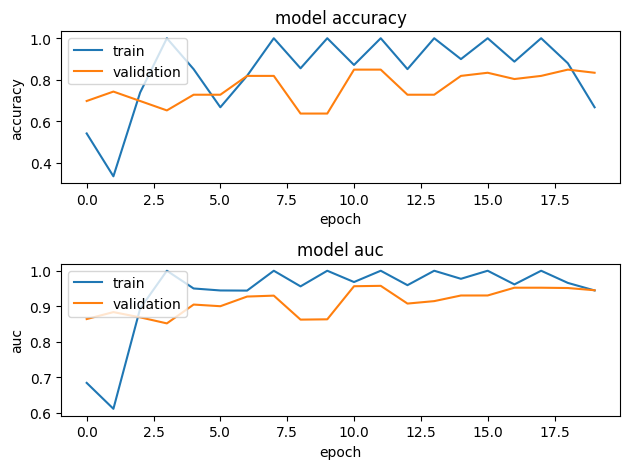

In [13]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')


# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc'])
ax2.plot(history.history['val_auc'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')


# used to keep plots from overlapping
fig.tight_layout()
